## (Stereo) Visual Odometry

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import cv2

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

In [2]:
class Dataset_Handler():
    def __init__(self, lidar=False, progress_bar=True):
        import pandas as pd
        import os
        import cv2

        self.left_image_files = os.listdir('./data/image_02/data')
        self.right_image_files = os.listdir('./data/image_03/data')
        self.left_image_files.sort()
        self.right_image_files.sort()

        self.num_frames = len(self.left_image_files)

        self.reset_frames()
            # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread('./data/image_02/data/' 
                                               + self.left_image_files[0], 0)
        
        self.first_image_right = cv2.imread('./data/image_03/data/' 
                                               + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread('./data/image_02/data/' 
                                               + self.left_image_files[1], 0)
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread('./data/image_02/data/'+ name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread('./data/image_03/data/' + name_right, 0)
                            for name_right in self.right_image_files)
    
    def __len__(self):
        return min(len(self.left_image_files), len(self.right_image_files))
    
    def __getitem__(self, idx):
        return (cv2.imread('./data/image_02/data/' 
                           + self.left_image_files[idx], 0), 
            cv2.imread('./data/image_03/data/' + self.right_image_files[idx],0))

#### disparity map and depth map
Unlike the simulation dataset we used in the tutorial, this time we are going to use a real driving dataset. Therefore we don't have depth images that you need to use for PnP directly, however, we have stereo images in this dataset, so the depth map can be generated from that.

In [3]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    # Feel free to read OpenCV documentation and tweak these values. These work well
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

Time to compute disparity map using StereoSGBM: 0:00:00.155050


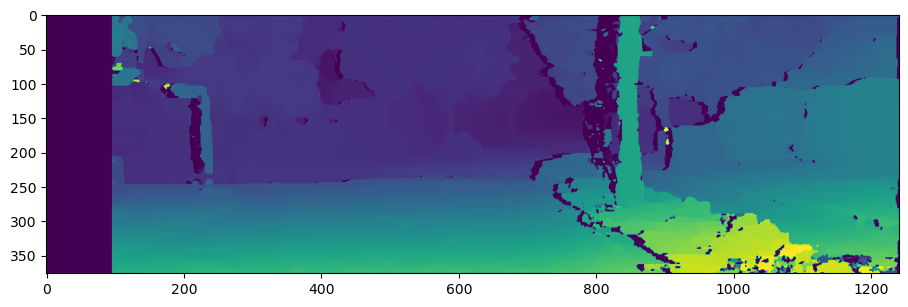

In [4]:
handler = Dataset_Handler()
left = handler.first_image_left
right = handler.first_image_right
disp = compute_left_disparity_map(left, 
                                  right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

In [5]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [6]:
P0 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   4.538225e+01],
               [  0.    ,7.188560e+02 , 1.852157e+02,   -1.130887e-01],
               [  0.    ,   0.    ,   1.    ,   3.779761e-03]])
P1 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   -3.372877e+02],
               [  0.    ,7.188560e+02 , 1.852157e+02,   2.369057e+00],
               [  0.    ,   0.    ,   1.    ,   4.915215e-03]])


Time to compute disparity map using StereoSGBM: 0:00:00.125397


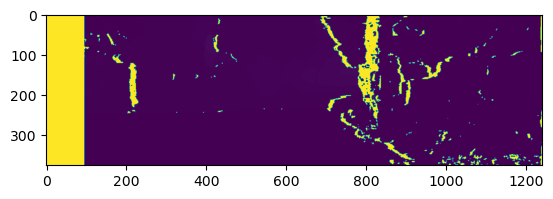

In [7]:
depth = stereo_2_depth(left, 
                       right, 
                       P0, 
                       P1,
                       matcher='sgbm',
                       verbose=True)
plt.imshow(depth)

In [8]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)

In [9]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Your task:

In [10]:
def extract_features(image, detector='orb', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image
    mask -- Masks for each input image specifying where to look for keypoints

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    feature_detector = None
    if detector == 'orb':
        feature_detector = cv2.ORB_create()
    elif detector == 'sift':
        feature_detector = cv2.SIFT_create() 
    
    if mask is not None:
        image = cv2.bitwise_and(image, mask)
    
    kp = feature_detector.detect(image)
    kp, des = feature_detector.compute(image, kp)
    
    return kp, des

In [11]:
def match_features(des1, des2, matching='BF', detector='sift', k=2):
    """
    Match features from two images
    You can set nfeatures to 500 for a faster computation

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    matcher = cv2.BFMatcher()
    if matching == 'FLANN':
        matcher = cv2.FlannBasedMatcher()
    
    matches = matcher.knnMatch(des1, des2, k=k)
    print(len(matches))

    return matches

In [12]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m,n in matches:
        if m.distance < dist_threshold * n.distance:
            filtered_match.append(m)

    return filtered_match

In [13]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

### check your implementation here

Time to compute disparity map using StereoSGBM: 0:00:00.109167
500
Number of matches before filtering: 500
Number of matches after filtering: 104


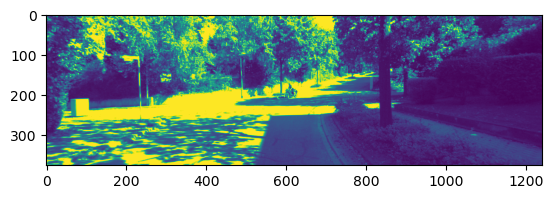

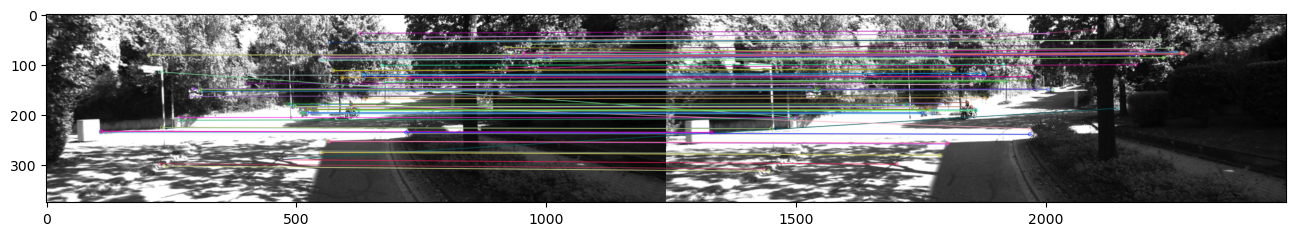

In [14]:
image_left = handler.first_image_left
plt.imshow(image_left)
image_right = handler.first_image_right 
image_plus1 = handler.second_image_left 
depth = stereo_2_depth(image_left, image_right, P0,  P1, matcher='sgbm', verbose=True) 
kp0, des0 = extract_features(image_left, 'orb') 
kp1, des1 = extract_features(image_plus1, 'orb') 
matches = match_features(des0, des1, matching='BF', detector='orb') 
print('Number of matches before filtering:', len(matches)) 
matches = filter_matches_distance(matches, 0.8) 
print('Number of matches after filtering:', len(matches)) 
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [15]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera intrinsic calibration matrix 
    
    Optional arguments:
    depth1 -- Depth map of the first frame. Set to None to use Essential Matrix decomposition
    max_depth -- Threshold of depth to ignore matched features. 3000 is default

    Returns:
    rmat -- estimated 3x3 rotation matrix
    tvec -- estimated 3x1 translation vector
    image1_points -- matched feature pixel coordinates in the first image. 
                     image1_points[i] = [u, v] -> pixel coordinates of i-th match
    image2_points -- matched feature pixel coordinates in the second image. 
                     image2_points[i] = [u, v] -> pixel coordinates of i-th match
               
    """
    image1_points = [kp1[m.queryIdx].pt for m in match]
    image2_points = [kp2[m.trainIdx].pt for m in match]
    
    object_points = []
    
    if depth1 is not None:
        pts1 = []
        pts2 = []
        for i, pt in enumerate(image1_points):
            depth = depth1[int(pt[1]), int(pt[0])]
            if  0 < depth < max_depth:
                pts1.append(pt)
                pts2.append(image2_points[i])
                
                #x = (pt[0] - k[0][2]) * depth / k[0][0]
                #y = (pt[1] - k[1][2]) * depth / k[1][1]
                p_c = np.linalg.inv(k) @ (depth * np.array([pt[0], pt[1], 1]))
                
                #object_points.append((x,y,depth))
                object_points.append(p_c)
                
        image1_points = np.array(pts1)
        image2_points = np.array(pts2)
        object_points = np.vstack(object_points)
        
        success, rvec, tvec, _ = cv2.solvePnPRansac(object_points, image2_points, k, None)
        if success:
            rmat, _ = cv2.Rodrigues(rvec)
        else:
            print("ERROR IN ROGRIGUES")
    
    else:
        E, mask = cv2.findEssentialMat(image1_points, image2_points, k, mathod=cv2.RANSAC, prob=0.9999, threshold=1.0)
        success, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)

    return rmat, tvec, image1_points,image2_points

In [16]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='sgbm', mask=None, depth_type='stereo'):
    '''
    Function to perform visual odometry on a sequence from the KITTI visual odometry dataset.
    Takes as input a Data_Handler object and optional parameters.
    
    Arguments:
    handler -- Data_Handler object instance
    
    Optional Arguments:
    detector -- (str) can be 'sift' or 'orb'. Default is 'sift'.
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'. Default is 'BF'.
    filter_match_distance -- (float) value for ratio test on matched features. Default is None.
    stereo_matcher -- (str) can be 'bm' (faster) or 'sgbm' (more accurate). Default is 'bm'.
    mask -- (array) mask to reduce feature search area to where depth information available.
    depth_type -- (str) can be 'stereo' or set to None to use Essential matrix decomposition.
                        Note that scale will be incorrect with no depth used.
   
    Returns:
    trajectory -- Array of shape Nx3x4 of estimated poses of vehicle for each computed frame.
    
    '''
    P0 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   4.538225e+01],
               [  0.    ,7.188560e+02 , 1.852157e+02,   -1.130887e-01],
               [  0.    ,   0.    ,   1.    ,   3.779761e-03]])
    P1 = np.array([[7.188560e+02 ,   0.    ,  6.071928e+02,   -3.372877e+02],
               [  0.    ,7.188560e+02 , 1.852157e+02,   2.369057e+00],
               [  0.    ,   0.    ,   1.    ,   4.915215e-03]])
    
    K, r, t = decompose_projection_matrix(P0)
    
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    
    # [x, y, z, rad]
    position = np.hstack((r, t))
    
    # Create variables for computation
    trajectory = np.zeros((len(handler), 3, 4))
    robot_pose = np.zeros((len(handler), 4, 4))
    
    # Initialize camera pose
    robot_pose[0] = np.eye(4)
    
    for i in range(len(handler)-1):
        left_image, right_image = handler[i]
        left_image_plus, _ = handler[i+1]
        kp0, des0 = extract_features(left_image, detector) 
        kp1, des1 = extract_features(left_image_plus, detector) 
        matches = match_features(des0, des1, matching=matching, detector=detector) 
        matches = filter_matches_distance(matches, filter_match_distance) 
        
        depth = stereo_2_depth(left_image, 
                       right_image, 
                       P0, 
                       P1,
                       matcher=stereo_matcher,
                       verbose=True)
        
        rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, K, depth1=depth)
        
        relative_pose = np.eye(4)
        relative_pose[:3, :3] = rmat
        relative_pose[:3, 3] = tvec.T
        
        # current_pose = np.dot(trajectory[-1], relative_pose)
        robot_pose[i+1] = robot_pose[i] @ np.linalg.inv(relative_pose)
        position = robot_pose[i+1] @ np.array([0,0,0,1])
        
        print(np.shape(robot_pose), np.shape(position))
        print(np.shape(robot_pose[i+1][:3, :]))
        print(np.shape(trajectory))
        
        trajectory[i+1, :] = robot_pose[i+1][:3, :]
        trajectory[i+1, :, 3] = position[:3]
        
        print(trajectory[i+1])
        print(robot_pose[i+1])
        # trajectory = np.vstack((trajectory, current_pose[:3][np.newaxis,:]))
    return trajectory

Generating disparities with StereoBM
Detecting features with SIFT and matching with FLANN
Filtering feature matches at threshold of 0.5*distance
5362
Time to compute disparity map using StereoBM: 0:00:00.039036
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 0.99999545 -0.00249525 -0.00169456 -0.00429649]
 [ 0.00249842  0.99999512  0.00187395 -0.01103596]
 [ 0.00168987 -0.00187817  0.99999681  0.79841785]]
[[ 0.99999545 -0.00249525 -0.00169456 -0.00429649]
 [ 0.00249842  0.99999512  0.00187395 -0.01103596]
 [ 0.00168987 -0.00187817  0.99999681  0.79841785]
 [ 0.          0.          0.          1.        ]]
5193
Time to compute disparity map using StereoBM: 0:00:00.047290
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 0.99998833 -0.00353786 -0.00329093 -0.01171565]
 [ 0.00355082  0.99998593  0.00394076 -0.02366296]
 [ 0.00327695 -0.0039524   0.99998682  1.57750274]]
[[ 0.99998833 -0.00353786 -0.00329093 -0.01171565]
 [ 0.00355082  0.99998593  0.00394076 -0.02366296]
 [ 0.00327695 -0.0039524   0.9999868

4437
Time to compute disparity map using StereoBM: 0:00:00.044405
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 0.99510991  0.0123772  -0.09799529 -0.3636193 ]
 [-0.01385857  0.99979954 -0.01445055 -0.23721743]
 [ 0.09779679  0.01573797  0.99508196 11.83867167]]
[[ 0.99510991  0.0123772  -0.09799529 -0.3636193 ]
 [-0.01385857  0.99979954 -0.01445055 -0.23721743]
 [ 0.09779679  0.01573797  0.99508196 11.83867167]
 [ 0.          0.          0.          1.        ]]
4431
Time to compute disparity map using StereoBM: 0:00:00.057668
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 9.91693292e-01  9.51224469e-03 -1.28272877e-01 -4.44371039e-01]
 [-1.14529688e-02  9.99830713e-01 -1.44005340e-02 -2.50280157e-01]
 [ 1.28114180e-01  1.57500182e-02  9.91634355e-01  1.23965900e+01]]
[[ 9.91693292e-01  9.51224469e-03 -1.28272877e-01 -4.44371039e-01]
 [-1.14529688e-02  9.99830713e-01 -1.44005340e-02 -2.50280157e-01]
 [ 1.28114180e-01  1.57500182e-02  9.91634355e-01  1.23965900e+01]
 [ 0.00000000e+00  0.00000000e+00 

4260
Time to compute disparity map using StereoBM: 0:00:00.024683
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 7.10635236e-01  3.86366785e-02 -7.02498945e-01 -4.21336413e+00]
 [-1.49308625e-02  9.99094300e-01  3.98453101e-02 -2.62381073e-01]
 [ 7.03402182e-01 -1.78265662e-02  7.10568493e-01  1.91899151e+01]]
[[ 7.10635236e-01  3.86366785e-02 -7.02498945e-01 -4.21336413e+00]
 [-1.49308625e-02  9.99094300e-01  3.98453101e-02 -2.62381073e-01]
 [ 7.03402182e-01 -1.78265662e-02  7.10568493e-01  1.91899151e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4808
Time to compute disparity map using StereoBM: 0:00:00.026279
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 6.76975306e-01  3.69708492e-02 -7.35076589e-01 -4.67877830e+00]
 [-1.20889834e-02  9.99161405e-01  3.91196003e-02 -2.34231537e-01]
 [ 7.35906442e-01 -1.75966747e-02  6.76854538e-01  1.95933394e+01]]
[[ 6.76975306e-01  3.69708492e-02 -7.35076589e-01 -4.67877830e+00]
 [-1.20889834e-02  9.99161405e-01  3.91196003e-02 -2.342

4629
Time to compute disparity map using StereoBM: 0:00:00.032276
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.78058703e-01  5.34083576e-02 -9.24239777e-01 -1.31746301e+01]
 [-1.18869228e-02  9.98532287e-01  5.28391182e-02  1.21796369e-01]
 [ 9.25705309e-01 -8.98992163e-03  3.78138682e-01  2.38272990e+01]]
[[ 3.78058703e-01  5.34083576e-02 -9.24239777e-01 -1.31746301e+01]
 [-1.18869228e-02  9.98532287e-01  5.28391182e-02  1.21796369e-01]
 [ 9.25705309e-01 -8.98992163e-03  3.78138682e-01  2.38272990e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4794
Time to compute disparity map using StereoBM: 0:00:00.024187
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.76182862e-01  5.32841938e-02 -9.25012027e-01 -1.38711522e+01]
 [-9.41757676e-03  9.98513337e-01  5.36882179e-02  1.57309381e-01]
 [ 9.26497579e-01 -1.14852157e-02  3.76125413e-01  2.41097345e+01]]
[[ 3.76182862e-01  5.32841938e-02 -9.25012027e-01 -1.38711522e+01]
 [-9.41757676e-03  9.98513337e-01  5.36882179e-02  1.573

4770
Time to compute disparity map using StereoBM: 0:00:00.028314
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.77371084e-01  6.34468923e-02 -9.23886117e-01 -2.46262619e+01]
 [-2.06713307e-03  9.97705480e-01  6.76720158e-02  7.41337635e-01]
 [ 9.26059821e-01 -2.36276664e-02  3.76636352e-01  2.84364863e+01]]
[[ 3.77371084e-01  6.34468923e-02 -9.23886117e-01 -2.46262619e+01]
 [-2.06713307e-03  9.97705480e-01  6.76720158e-02  7.41337635e-01]
 [ 9.26059821e-01 -2.36276664e-02  3.76636352e-01  2.84364863e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4818
Time to compute disparity map using StereoBM: 0:00:00.028914
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.77456964e-01  6.12999764e-02 -9.23995970e-01 -2.54658624e+01]
 [-1.63119501e-03  9.97849056e-01  6.55332054e-02  7.91923516e-01]
 [ 9.26025690e-01 -2.32287471e-02  3.76745068e-01  2.87747176e+01]]
[[ 3.77456964e-01  6.12999764e-02 -9.23995970e-01 -2.54658624e+01]
 [-1.63119501e-03  9.97849056e-01  6.55332054e-02  7.919

3810
Time to compute disparity map using StereoBM: 0:00:00.025047
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.80875763e-01  7.09144033e-02 -9.21902815e-01 -3.76917325e+01]
 [ 3.37281630e-04  9.97043863e-01  7.68337310e-02  1.54827692e+00]
 [ 9.24626162e-01 -2.95750468e-02  3.79725923e-01  3.37779939e+01]]
[[ 3.80875763e-01  7.09144033e-02 -9.21902815e-01 -3.76917325e+01]
 [ 3.37281630e-04  9.97043863e-01  7.68337310e-02  1.54827692e+00]
 [ 9.24626162e-01 -2.95750468e-02  3.79725923e-01  3.37779939e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3699
Time to compute disparity map using StereoBM: 0:00:00.024294
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.81249187e-01  7.36059087e-02 -9.21537426e-01 -3.85837891e+01]
 [ 2.85394993e-03  9.96726879e-01  8.07922193e-02  1.60934557e+00]
 [ 9.24467908e-01 -3.34319896e-02  3.79791245e-01  3.41503260e+01]]
[[ 3.81249187e-01  7.36059087e-02 -9.21537426e-01 -3.85837891e+01]
 [ 2.85394993e-03  9.96726879e-01  8.07922193e-02  1.609

4676
Time to compute disparity map using StereoBM: 0:00:00.024205
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.75891130e-01  7.37331421e-02 -9.23725761e-01 -5.12551057e+01]
 [-1.94523061e-02  9.97237601e-01  7.16852504e-02  2.41040372e+00]
 [ 9.26459641e-01 -8.97725355e-03  3.76287049e-01  3.92849720e+01]]
[[ 3.75891130e-01  7.37331421e-02 -9.23725761e-01 -5.12551057e+01]
 [-1.94523061e-02  9.97237601e-01  7.16852504e-02  2.41040372e+00]
 [ 9.26459641e-01 -8.97725355e-03  3.76287049e-01  3.92849720e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4749
Time to compute disparity map using StereoBM: 0:00:00.023941
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.75149897e-01  7.51001618e-02 -9.23916944e-01 -5.21699386e+01]
 [-2.04026803e-02  9.97140206e-01  7.27677177e-02  2.46890954e+00]
 [ 9.26739599e-01 -8.44841979e-03  3.75609291e-01  3.96511425e+01]]
[[ 3.75149897e-01  7.51001618e-02 -9.23916944e-01 -5.21699386e+01]
 [-2.04026803e-02  9.97140206e-01  7.27677177e-02  2.468

3501
Time to compute disparity map using StereoBM: 0:00:00.027120
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.71852150e-01  8.27545073e-02 -9.24595950e-01 -6.40680423e+01]
 [-2.09551016e-02  9.96512979e-01  8.07636471e-02  3.24160377e+00]
 [ 9.28055420e-01 -1.06571337e-02  3.72289622e-01  4.43929937e+01]]
[[ 3.71852150e-01  8.27545073e-02 -9.24595950e-01 -6.40680423e+01]
 [-2.09551016e-02  9.96512979e-01  8.07636471e-02  3.24160377e+00]
 [ 9.28055420e-01 -1.06571337e-02  3.72289622e-01  4.43929937e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3574
Time to compute disparity map using StereoBM: 0:00:00.026248
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.71865924e-01  8.42083732e-02 -9.24459131e-01 -6.48294593e+01]
 [-2.22441363e-02  9.96399384e-01  8.18136058e-02  3.29119324e+00]
 [ 9.28019899e-01 -9.85989718e-03  3.72400120e-01  4.46951022e+01]]
[[ 3.71865924e-01  8.42083732e-02 -9.24459131e-01 -6.48294593e+01]
 [-2.22441363e-02  9.96399384e-01  8.18136058e-02  3.291

3954
Time to compute disparity map using StereoBM: 0:00:00.025679
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.81580194e-01  8.14237824e-02 -9.20742485e-01 -7.39658897e+01]
 [-1.74941641e-02  9.96570357e-01  8.08794017e-02  3.90940816e+00]
 [ 9.24170174e-01 -1.47543576e-02  3.81695951e-01  4.84406352e+01]]
[[ 3.81580194e-01  8.14237824e-02 -9.20742485e-01 -7.39658897e+01]
 [-1.74941641e-02  9.96570357e-01  8.08794017e-02  3.90940816e+00]
 [ 9.24170174e-01 -1.47543576e-02  3.81695951e-01  4.84406352e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4104
Time to compute disparity map using StereoBM: 0:00:00.059742
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.82644471e-01  8.00915398e-02 -9.20417598e-01 -7.45599148e+01]
 [-1.56233414e-02  9.96653909e-01  8.02302794e-02  3.95006777e+00]
 [ 9.23763563e-01 -1.63196744e-02  3.82615405e-01  4.86932800e+01]]
[[ 3.82644471e-01  8.00915398e-02 -9.20417598e-01 -7.45599148e+01]
 [-1.56233414e-02  9.96653909e-01  8.02302794e-02  3.950

4580
Time to compute disparity map using StereoBM: 0:00:00.031408
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 3.13275291e-01  7.01370524e-02 -9.47068839e-01 -8.15765457e+01]
 [ 8.77950655e-03  9.97012495e-01  7.67398495e-02  4.42315326e+00]
 [ 9.49621773e-01 -3.23554958e-02  3.11723611e-01  5.15043763e+01]]
[[ 3.13275291e-01  7.01370524e-02 -9.47068839e-01 -8.15765457e+01]
 [ 8.77950655e-03  9.97012495e-01  7.67398495e-02  4.42315326e+00]
 [ 9.49621773e-01 -3.23554958e-02  3.11723611e-01  5.15043763e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4914
Time to compute disparity map using StereoBM: 0:00:00.030710
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[ 2.86263861e-01  6.83367630e-02 -9.55710777e-01 -8.20510883e+01]
 [ 1.28072793e-02  9.97091364e-01  7.51317859e-02  4.45457308e+00]
 [ 9.58065225e-01 -3.37475700e-02  2.84556015e-01  5.16315587e+01]]
[[ 2.86263861e-01  6.83367630e-02 -9.55710777e-01 -8.20510883e+01]
 [ 1.28072793e-02  9.97091364e-01  7.51317859e-02  4.454

4959
Time to compute disparity map using StereoBM: 0:00:00.044977
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-4.38593509e-01  9.02223603e-02 -8.94145211e-01 -8.87500807e+01]
 [ 6.76665482e-02  9.95438825e-01  6.72516396e-02  4.85535146e+00]
 [ 8.96134461e-01 -3.10075874e-02 -4.42698044e-01  5.07475425e+01]]
[[-4.38593509e-01  9.02223603e-02 -8.94145211e-01 -8.87500807e+01]
 [ 6.76665482e-02  9.95438825e-01  6.72516396e-02  4.85535146e+00]
 [ 8.96134461e-01 -3.10075874e-02 -4.42698044e-01  5.07475425e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
5033
Time to compute disparity map using StereoBM: 0:00:00.041959
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-4.96469384e-01  9.32332628e-02 -8.63032856e-01 -8.92127754e+01]
 [ 7.31359062e-02  9.95172979e-01  6.54360785e-02  4.88240443e+00]
 [ 8.64967797e-01 -3.06316805e-02 -5.00891615e-01  5.04467182e+01]]
[[-4.96469384e-01  9.32332628e-02 -8.63032856e-01 -8.92127754e+01]
 [ 7.31359062e-02  9.95172979e-01  6.54360785e-02  4.882

5333
Time to compute disparity map using StereoBM: 0:00:00.019311
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.20083681e-01  8.57951718e-02 -3.82210947e-01 -9.42339058e+01]
 [ 8.54071644e-02  9.96183233e-01  1.80161597e-02  5.15503179e+00]
 [ 3.82297836e-01 -1.60671786e-02 -9.23899459e-01  4.29378352e+01]]
[[-9.20083681e-01  8.57951718e-02 -3.82210947e-01 -9.42339058e+01]
 [ 8.54071644e-02  9.96183233e-01  1.80161597e-02  5.15503179e+00]
 [ 3.82297836e-01 -1.60671786e-02 -9.23899459e-01  4.29378352e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4947
Time to compute disparity map using StereoBM: 0:00:00.018412
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.28198219e-01  8.59502960e-02 -3.62022944e-01 -9.45039441e+01]
 [ 8.49280831e-02  9.96210309e-01  1.87680797e-02  5.16685656e+00]
 [ 3.62264111e-01 -1.33254166e-02 -9.31980229e-01  4.22206800e+01]]
[[-9.28198219e-01  8.59502960e-02 -3.62022944e-01 -9.45039441e+01]
 [ 8.49280831e-02  9.96210309e-01  1.87680797e-02  5.166

4376
Time to compute disparity map using StereoBM: 0:00:00.015645
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.76554937e-01  7.25048288e-02 -2.02690662e-01 -9.75130529e+01]
 [ 6.96877785e-02  9.97347575e-01  2.10101987e-02  5.32015541e+00]
 [ 2.03676381e-01  6.39255127e-03 -9.79017399e-01  3.14459726e+01]]
[[-9.76554937e-01  7.25048288e-02 -2.02690662e-01 -9.75130529e+01]
 [ 6.96877785e-02  9.97347575e-01  2.10101987e-02  5.32015541e+00]
 [ 2.03676381e-01  6.39255127e-03 -9.79017399e-01  3.14459726e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4724
Time to compute disparity map using StereoBM: 0:00:00.014842
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.78784863e-01  7.53497831e-02 -1.90532416e-01 -9.76642731e+01]
 [ 7.27488894e-02  9.97137134e-01  2.06188273e-02  5.32716173e+00]
 [ 1.91540571e-01  6.32037440e-03 -9.81464346e-01  3.06593703e+01]]
[[-9.78784863e-01  7.53497831e-02 -1.90532416e-01 -9.76642731e+01]
 [ 7.27488894e-02  9.97137134e-01  2.06188273e-02  5.327

6561
Time to compute disparity map using StereoBM: 0:00:00.055841
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.98886516e-01  4.49469547e-02 -1.43352228e-02 -9.86049841e+01]
 [ 4.46719066e-02  9.98821730e-01  1.89623827e-02  5.35005998e+00]
 [ 1.51706334e-02  1.83008867e-02 -9.99717425e-01  1.97372975e+01]]
[[-9.98886516e-01  4.49469547e-02 -1.43352228e-02 -9.86049841e+01]
 [ 4.46719066e-02  9.98821730e-01  1.89623827e-02  5.35005998e+00]
 [ 1.51706334e-02  1.83008867e-02 -9.99717425e-01  1.97372975e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
6389
Time to compute disparity map using StereoBM: 0:00:00.053800
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.98999711e-01  4.47013131e-02 -1.17051918e-03 -9.85967492e+01]
 [ 4.46581924e-02  9.98690053e-01  2.49764817e-02  5.35163240e+00]
 [ 2.28546739e-03  2.48992247e-02 -9.99687354e-01  1.89687422e+01]]
[[-9.98999711e-01  4.47013131e-02 -1.17051918e-03 -9.85967492e+01]
 [ 4.46581924e-02  9.98690053e-01  2.49764817e-02  5.351

4808
Time to compute disparity map using StereoBM: 0:00:00.051630
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.86727219e-01  3.79181516e-02  1.57897461e-01 -9.75293173e+01]
 [ 4.12410141e-02  9.98990300e-01  1.78202077e-02  5.46107392e+00]
 [-1.57062323e-01  2.40955354e-02 -9.87294704e-01  8.26094394e+00]]
[[-9.86727219e-01  3.79181516e-02  1.57897461e-01 -9.75293173e+01]
 [ 4.12410141e-02  9.98990300e-01  1.78202077e-02  5.46107392e+00]
 [-1.57062323e-01  2.40955354e-02 -9.87294704e-01  8.26094394e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
5250
Time to compute disparity map using StereoBM: 0:00:00.043438
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.85328587e-01  3.76328609e-02  1.66467247e-01 -9.73898577e+01]
 [ 4.11283285e-02  9.98998859e-01  1.75994547e-02  5.46462855e+00]
 [-1.65638272e-01  2.41877654e-02 -9.85889910e-01  7.48452837e+00]]
[[-9.85328587e-01  3.76328609e-02  1.66467247e-01 -9.73898577e+01]
 [ 4.11283285e-02  9.98998859e-01  1.75994547e-02  5.464

4035
Time to compute disparity map using StereoBM: 0:00:00.062221
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.67225025e-01  2.71310050e-02  2.52467144e-01 -9.48098333e+01]
 [ 3.21710611e-02  9.99356599e-01  1.58559503e-02  5.56003321e+00]
 [-2.51874518e-01  2.34584079e-02 -9.67475545e-01 -3.67648268e+00]]
[[-9.67225025e-01  2.71310050e-02  2.52467144e-01 -9.48098333e+01]
 [ 3.21710611e-02  9.99356599e-01  1.58559503e-02  5.56003321e+00]
 [-2.51874518e-01  2.34584079e-02 -9.67475545e-01 -3.67648268e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4077
Time to compute disparity map using StereoBM: 0:00:00.031373
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.66381607e-01  2.75343536e-02  2.55633428e-01 -9.45928118e+01]
 [ 3.29964594e-02  9.99309139e-01  1.71019897e-02  5.56422439e+00]
 [-2.54985928e-01  2.49620463e-02 -9.66622508e-01 -4.47872499e+00]]
[[-9.66381607e-01  2.75343536e-02  2.55633428e-01 -9.45928118e+01]
 [ 3.29964594e-02  9.99309139e-01  1.71019897e-02  5.564

4937
Time to compute disparity map using StereoBM: 0:00:00.069418
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.49323750e-01  2.11290477e-02  3.13588871e-01 -9.12066104e+01]
 [ 3.16273903e-02  9.99095370e-01  2.84279828e-02  5.73278108e+00]
 [-3.12704533e-01  3.69053569e-02 -9.49133220e-01 -1.56274238e+01]]
[[-9.49323750e-01  2.11290477e-02  3.13588871e-01 -9.12066104e+01]
 [ 3.16273903e-02  9.99095370e-01  2.84279828e-02  5.73278108e+00]
 [-3.12704533e-01  3.69053569e-02 -9.49133220e-01 -1.56274238e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
5218
Time to compute disparity map using StereoBM: 0:00:00.035133
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.48297921e-01  2.05601658e-02  3.16714908e-01 -9.09415599e+01]
 [ 3.14699609e-02  9.99073105e-01  2.93695988e-02  5.74666849e+00]
 [-3.15817503e-01  3.78181353e-02 -9.48065975e-01 -1.64105862e+01]]
[[-9.48297921e-01  2.05601658e-02  3.16714908e-01 -9.09415599e+01]
 [ 3.14699609e-02  9.99073105e-01  2.93695988e-02  5.746

3241
Time to compute disparity map using StereoBM: 0:00:00.065967
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.43346573e-01  5.28744828e-03  3.31766917e-01 -8.73212931e+01]
 [ 2.19276270e-02  9.98680715e-01  4.64328369e-02  6.00177739e+00]
 [-3.31083710e-01  5.10771187e-02 -9.42217971e-01 -2.67559963e+01]]
[[-9.43346573e-01  5.28744828e-03  3.31766917e-01 -8.73212931e+01]
 [ 2.19276270e-02  9.98680715e-01  4.64328369e-02  6.00177739e+00]
 [-3.31083710e-01  5.10771187e-02 -9.42217971e-01 -2.67559963e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3138
Time to compute disparity map using StereoBM: 0:00:00.047950
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.43842302e-01  5.04285955e-03  3.30357804e-01 -8.70962171e+01]
 [ 2.19057250e-02  9.98638545e-01  4.73412640e-02  6.02393211e+00]
 [-3.29669301e-01  5.19194148e-02 -9.42667771e-01 -2.74030172e+01]]
[[-9.43842302e-01  5.04285955e-03  3.30357804e-01 -8.70962171e+01]
 [ 2.19057250e-02  9.98638545e-01  4.73412640e-02  6.023

2529
Time to compute disparity map using StereoBM: 0:00:00.050362
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.49736802e-01  2.37248989e-03  3.13040537e-01 -8.42557490e+01]
 [ 1.77190734e-02  9.98775579e-01  4.61884946e-02  6.33391954e+00]
 [-3.12547662e-01  4.94137014e-02 -9.48615963e-01 -3.58824831e+01]]
[[-9.49736802e-01  2.37248989e-03  3.13040537e-01 -8.42557490e+01]
 [ 1.77190734e-02  9.98775579e-01  4.61884946e-02  6.33391954e+00]
 [-3.12547662e-01  4.94137014e-02 -9.48615963e-01 -3.58824831e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2572
Time to compute disparity map using StereoBM: 0:00:00.044623
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.49736440e-01  5.10898749e-03  3.13008933e-01 -8.40615196e+01]
 [ 2.15965561e-02  9.98553951e-01  4.92300222e-02  6.35579544e+00]
 [-3.12304791e-01  5.35154610e-02 -9.48473412e-01 -3.64920607e+01]]
[[-9.49736440e-01  5.10898749e-03  3.13008933e-01 -8.40615196e+01]
 [ 2.15965561e-02  9.98553951e-01  4.92300222e-02  6.355

4024
Time to compute disparity map using StereoBM: 0:00:00.051617
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.55861175e-01  1.20666227e-03  2.93816197e-01 -8.11224516e+01]
 [ 1.88565221e-02  9.98182021e-01  5.72458190e-02  6.69038719e+00]
 [-2.93212969e-01  6.02594074e-02 -9.54146193e-01 -4.56116558e+01]]
[[-9.55861175e-01  1.20666227e-03  2.93816197e-01 -8.11224516e+01]
 [ 1.88565221e-02  9.98182021e-01  5.72458190e-02  6.69038719e+00]
 [-2.93212969e-01  6.02594074e-02 -9.54146193e-01 -4.56116558e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4136
Time to compute disparity map using StereoBM: 0:00:00.043876
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.56663468e-01  3.32267136e-03  2.91176869e-01 -8.09106962e+01]
 [ 2.08877007e-02  9.98142106e-01  5.72366961e-02  6.72100337e+00]
 [-2.90445715e-01  6.08382715e-02 -9.54955492e-01 -4.63254747e+01]]
[[-9.56663468e-01  3.32267136e-03  2.91176869e-01 -8.09106962e+01]
 [ 2.08877007e-02  9.98142106e-01  5.72366961e-02  6.721

4375
Time to compute disparity map using StereoBM: 0:00:00.056115
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.61464561e-01  1.59820324e-02  2.74463975e-01 -7.78584212e+01]
 [ 3.36877019e-02  9.97634695e-01  5.99178872e-02  7.16962328e+00]
 [-2.72857174e-01  6.68549857e-02 -9.59728802e-01 -5.69911635e+01]]
[[-9.61464561e-01  1.59820324e-02  2.74463975e-01 -7.78584212e+01]
 [ 3.36877019e-02  9.97634695e-01  5.99178872e-02  7.16962328e+00]
 [-2.72857174e-01  6.68549857e-02 -9.59728802e-01 -5.69911635e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4210
Time to compute disparity map using StereoBM: 0:00:00.046943
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.61688079e-01  1.59327629e-02  2.73682636e-01 -7.76306837e+01]
 [ 3.33414598e-02  9.97696545e-01  5.90758045e-02  7.20759040e+00]
 [-2.72110980e-01  6.59374756e-02 -9.60004096e-01 -5.77916865e+01]]
[[-9.61688079e-01  1.59327629e-02  2.73682636e-01 -7.76306837e+01]
 [ 3.33414598e-02  9.97696545e-01  5.90758045e-02  7.207

3706
Time to compute disparity map using StereoBM: 0:00:00.055050
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.72062096e-01  2.24130863e-02  2.33651309e-01 -7.45341569e+01]
 [ 3.99834827e-02  9.96693435e-01  7.07355425e-02  7.87065916e+00]
 [-2.31293324e-01  7.81015328e-02 -9.69744064e-01 -6.97788546e+01]]
[[-9.72062096e-01  2.24130863e-02  2.33651309e-01 -7.45341569e+01]
 [ 3.99834827e-02  9.96693435e-01  7.07355425e-02  7.87065916e+00]
 [-2.31293324e-01  7.81015328e-02 -9.69744064e-01 -6.97788546e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3624
Time to compute disparity map using StereoBM: 0:00:00.051958
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.72691639e-01  2.39306080e-02  2.30864249e-01 -7.43266589e+01]
 [ 4.08680721e-02  9.96788607e-01  6.88641685e-02  7.92558944e+00]
 [-2.28474892e-01  7.64185777e-02 -9.70545942e-01 -7.06792388e+01]]
[[-9.72691639e-01  2.39306080e-02  2.30864249e-01 -7.43266589e+01]
 [ 4.08680721e-02  9.96788607e-01  6.88641685e-02  7.925

3164
Time to compute disparity map using StereoBM: 0:00:00.046117
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.79505217e-01  1.78505186e-02  2.00626241e-01 -7.15011567e+01]
 [ 3.35942144e-02  9.96591528e-01  7.53442449e-02  8.72291203e+00]
 [-1.98597478e-01  8.05399620e-02 -9.76766275e-01 -8.37423305e+01]]
[[-9.79505217e-01  1.78505186e-02  2.00626241e-01 -7.15011567e+01]
 [ 3.35942144e-02  9.96591528e-01  7.53442449e-02  8.72291203e+00]
 [-1.98597478e-01  8.05399620e-02 -9.76766275e-01 -8.37423305e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3071
Time to compute disparity map using StereoBM: 0:00:00.046671
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.79930579e-01  1.82334857e-02  1.98503402e-01 -7.13055124e+01]
 [ 3.33921128e-02  9.96751725e-01  7.32868755e-02  8.78315779e+00]
 [-1.96522333e-01  7.84444983e-02 -9.77356349e-01 -8.46941886e+01]]
[[-9.79930579e-01  1.82334857e-02  1.98503402e-01 -7.13055124e+01]
 [ 3.33921128e-02  9.96751725e-01  7.32868755e-02  8.783

2540
Time to compute disparity map using StereoBM: 0:00:00.045633
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.87182534e-01  3.06172672e-02  1.56630862e-01 -6.88556803e+01]
 [ 4.34019089e-02  9.95940077e-01  7.88646808e-02  9.60845717e+00]
 [-1.53580332e-01  8.46519139e-02 -9.84503497e-01 -9.84311606e+01]]
[[-9.87182534e-01  3.06172672e-02  1.56630862e-01 -6.88556803e+01]
 [ 4.34019089e-02  9.95940077e-01  7.88646808e-02  9.60845717e+00]
 [-1.53580332e-01  8.46519139e-02 -9.84503497e-01 -9.84311606e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2833
Time to compute disparity map using StereoBM: 0:00:00.047583
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.87757018e-01  3.14858502e-02  1.52789773e-01 -6.87004542e+01]
 [ 4.41184752e-02  9.95817515e-01  8.00064836e-02  9.67694686e+00]
 [-1.49631660e-01  8.57678175e-02 -9.85014847e-01 -9.94393998e+01]]
[[-9.87757018e-01  3.14858502e-02  1.52789773e-01 -6.87004542e+01]
 [ 4.41184752e-02  9.95817515e-01  8.00064836e-02  9.676

2398
Time to compute disparity map using StereoBM: 0:00:00.035000
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.92344926e-01  3.87837756e-02  1.17249168e-01 -6.68433516e+01]
 [ 4.84820986e-02  9.95531986e-01  8.10280826e-02  1.06158088e+01]
 [-1.13582723e-01  8.60922923e-02 -9.89791434e-01 -1.13762543e+02]]
[[-9.92344926e-01  3.87837756e-02  1.17249168e-01 -6.68433516e+01]
 [ 4.84820986e-02  9.95531986e-01  8.10280826e-02  1.06158088e+01]
 [-1.13582723e-01  8.60922923e-02 -9.89791434e-01 -1.13762543e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2390
Time to compute disparity map using StereoBM: 0:00:00.029322
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.92599879e-01  3.63033016e-02  1.15877304e-01 -6.67153558e+01]
 [ 4.61897444e-02  9.95410990e-01  8.38061386e-02  1.06926943e+01]
 [-1.12303102e-01  8.85383062e-02 -9.89721669e-01 -1.14810749e+02]]
[[-9.92599879e-01  3.63033016e-02  1.15877304e-01 -6.67153558e+01]
 [ 4.61897444e-02  9.95410990e-01  8.38061386e-02  1.069

3867
Time to compute disparity map using StereoBM: 0:00:00.030091
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.97328917e-01  2.13714075e-02  6.98447896e-02 -6.53279685e+01]
 [ 2.72835865e-02  9.96022592e-01  8.48210022e-02  1.17204433e+01]
 [-6.77542441e-02  8.65000546e-02 -9.93945221e-01 -1.28878554e+02]]
[[-9.97328917e-01  2.13714075e-02  6.98447896e-02 -6.53279685e+01]
 [ 2.72835865e-02  9.96022592e-01  8.48210022e-02  1.17204433e+01]
 [-6.77542441e-02  8.65000546e-02 -9.93945221e-01 -1.28878554e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4157
Time to compute disparity map using StereoBM: 0:00:00.029132
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.97506854e-01  2.21078075e-02  6.70173209e-02 -6.52614933e+01]
 [ 2.76809688e-02  9.96131073e-01  8.34065277e-02  1.17863137e+01]
 [-6.49141003e-02  8.50536874e-02 -9.94259538e-01 -1.29815984e+02]]
[[-9.97506854e-01  2.21078075e-02  6.70173209e-02 -6.52614933e+01]
 [ 2.76809688e-02  9.96131073e-01  8.34065277e-02  1.178

4251
Time to compute disparity map using StereoBM: 0:00:00.037112
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.97695762e-01  1.31903064e-02  6.65521009e-02 -6.44077788e+01]
 [ 1.91187819e-02  9.95826146e-01  8.92455019e-02  1.27146018e+01]
 [-6.50971466e-02  9.03122541e-02 -9.93783708e-01 -1.42533806e+02]]
[[-9.97695762e-01  1.31903064e-02  6.65521009e-02 -6.44077788e+01]
 [ 1.91187819e-02  9.95826146e-01  8.92455019e-02  1.27146018e+01]
 [-6.50971466e-02  9.03122541e-02 -9.93783708e-01 -1.42533806e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4155
Time to compute disparity map using StereoBM: 0:00:00.034415
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.97702645e-01  1.25307288e-02  6.65763746e-02 -6.43524644e+01]
 [ 1.85308944e-02  9.95743440e-01  9.02862516e-02  1.27775263e+01]
 [-6.51616357e-02  9.13125517e-02 -9.93688069e-01 -1.43360331e+02]]
[[-9.97702645e-01  1.25307288e-02  6.65763746e-02 -6.43524644e+01]
 [ 1.85308944e-02  9.95743440e-01  9.02862516e-02  1.277

2692
Time to compute disparity map using StereoBM: 0:00:00.044408
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.98811586e-01  2.73107649e-03 -4.86616610e-02 -6.41328753e+01]
 [-2.26627916e-03  9.94746305e-01  1.02345749e-01  1.35651406e+01]
 [ 4.86855215e-02  1.02334401e-01 -9.93557945e-01 -1.53290031e+02]]
[[-9.98811586e-01  2.73107649e-03 -4.86616610e-02 -6.41328753e+01]
 [-2.26627916e-03  9.94746305e-01  1.02345749e-01  1.35651406e+01]
 [ 4.86855215e-02  1.02334401e-01 -9.93557945e-01 -1.53290031e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2702
Time to compute disparity map using StereoBM: 0:00:00.051829
(416, 4, 4) (4,)
(3, 4)
(416, 3, 4)
[[-9.97609154e-01  4.09733558e-03 -6.89868599e-02 -6.41898831e+01]
 [-3.31187204e-03  9.94259471e-01  1.06944548e-01  1.36187053e+01]
 [ 6.90290265e-02  1.06917336e-01 -9.91868780e-01 -1.53904628e+02]]
[[-9.97609154e-01  4.09733558e-03 -6.89868599e-02 -6.41898831e+01]
 [-3.31187204e-03  9.94259471e-01  1.06944548e-01  1.361

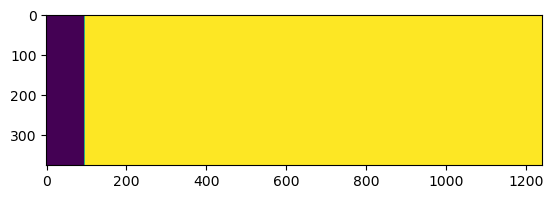

In [17]:
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask)
# You can set nfeatures to 500 and use FLANN based matcher for a faster computation
trajectory = visual_odometry(handler,
                                        filter_match_distance=0.5, 
                                        detector='sift', # you can use your favourite detector and matcher
                                        matching='FLANN',
                                        stereo_matcher='bm',
                                        mask=mask)

In [18]:
np.eye(4)[np.newaxis,:]

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

#### Load  gps data
Given that GPS have a noise following a normal distribution of 0 mean and 0.5 standard deviation 

In [19]:
gps_data = np.load('data/gps.npy')
gps_data.shape

(416, 2)

In [20]:
np.shape(trajectory)

(416, 3, 4)

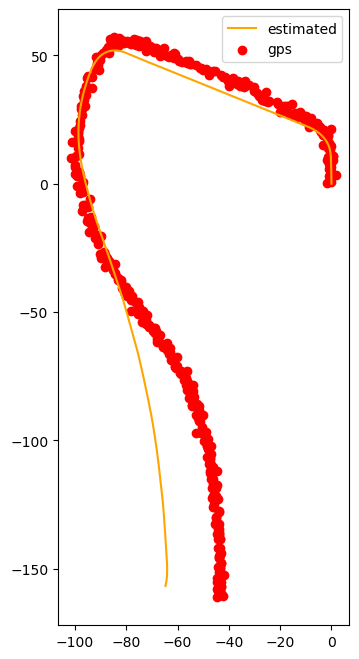

In [21]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(trajectory[:-1, :, 3][:, 0], 
        trajectory[:-1, :, 3][:, 2], 
        label='estimated', color='orange')
ax.scatter(gps_data[:,0],gps_data[:,1],
        label='gps',color='red')
ax.legend()

##### You might need this in following part

In [22]:
delta_pose = np.zeros((handler.num_frames-1,2))
bearing = np.zeros(handler.num_frames)
relative_angle = np.zeros(handler.num_frames-1)
distance = np.zeros(handler.num_frames-1)
for i in range(1,handler.num_frames):
    delta_pose[i-1,0] = trajectory[:, :, 3][i,0]-trajectory[:, :, 3][i-1,0]
    delta_pose[i-1,1] = trajectory[:, :, 3][i,2]-trajectory[:, :, 3][i-1,2]
    bearing[i] = np.arctan2(delta_pose[i-1,0],delta_pose[i-1,1])
    relative_angle[i-1] = bearing[i] - bearing[i-1]
    distance[i-1] = np.sqrt(np.square(delta_pose[i-1,0]) + np.square(delta_pose[i-1,1]))

## Extended Kalman Filter

Now please try to use EKF to fuse the visual odometry from cameras with gps.

For simplicity, set the state vector X = \begin{bmatrix}
 b \\
 x \\
 y
\end{bmatrix}
### Motion Model
\begin{align}
\mathbf{x}_{k} &= 
\begin{bmatrix}
1 &0 & 0 \\
0 &1 & 0\\
0 &0 & 1
\end{bmatrix}
\mathbf{x}_{k-1} +
\begin{bmatrix}
1 &0 \\
0 &sin(b)\\
0 &cos(b)
\end{bmatrix}
\left(
\begin{bmatrix}
\theta \\
d
\end{bmatrix}
+ \mathbf{w}_k
\right)
\, , \, \, \, \, \, \mathbf{w}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{Q}\right)
\end{align}

- $\mathbf{x}_k = \left[ b \, x \, y  \right]^T$ is the current bearing and 2d position of the vehicle
- $\theta $ is the change in bearing between frame k-1 and k, data is stored in "relative_angle"
- $d$ is the distance traveled between frame k-1 and k, data is stored in "distance"

The process noise $\mathbf{w}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{Q}$.


### Measurement Model

The measurement model from gps $\mathbf{y}_k = \left[x \, y \right]^T$.

\begin{align}
\mathbf{y}_k =
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}
x_k
+ \mathbf{n}_k
\, , \, \, \, \, \, \mathbf{n}_k = \mathcal{N}\left(\mathbf{0}, \mathbf{R}\right)
\end{align}


The gps measurement noise $\mathbf{n}_k$ has a (zero mean) normal distribution with a constant covariance $\mathbf{R}$.

In [23]:
from numpy.linalg import inv
init_x = np.array([0,0,0])
x_check_hist = [init_x]
P_init = np.diag([0, 0, 0])
P_check_hist = [P_init]
th_var = 0.01
d_var = 0.01
Q_km = np.diag([th_var, d_var])
cov_y = np.diag([1, 1])

for i in range(handler.num_frames-1):
    b = x_check_hist[-1][0]
    d = distance[i]
    x_check = np.zeros((3,))
    x_check[0] = b + relative_angle[i]
    x_check[1] = x_check_hist[-1][1] + d*np.sin(b)
    x_check[2] = x_check_hist[-1][2] + d*np.cos(b)
    
    # Motion Model
    F_km = np.mat([[1,0,0],
                   [d*np.cos(b),1,0],
                   [-d*np.sin(b),0,1]])
    L_km = np.mat([[1, 0],
                   [0, np.sin(b)],
                   [0, np.cos(b)]])

    # Propagate Uncertainty
    P_check = F_km.dot(P_check_hist[-1]).dot(F_km.T) + L_km.dot(Q_km).dot(L_km.T)
    
    
    H_k = np.matrix([[0, 1, 0],
                  [0, 0, 1]])
    M_k = np.eye(2)
    K_k = P_check.dot(H_k.T).dot(inv(H_k.dot(P_check).dot(H_k.T) + M_k.dot(cov_y).dot(M_k.T)))
    
    # Measurement Model
    y_k_l_predict = np.zeros([2, 1])
    y_k_l_predict[0] = x_check_hist[-1][1] + d*np.sin(b)
    y_k_l_predict[1] = x_check_hist[-1][2] + d*np.cos(b)
    y_k_l = np.mat([[gps_data[i,0]], [gps_data[i,1]]])
    add = K_k.dot(y_k_l - y_k_l_predict)
    add = np.array(add).flatten()
    x_check = x_check + add
    P_check = (np.eye(3) - K_k.dot(H_k)).dot(P_check)
    x_check_hist.append(x_check)
    P_check_hist.append(P_check)

In [24]:
x_check_hist = np.array(x_check_hist)

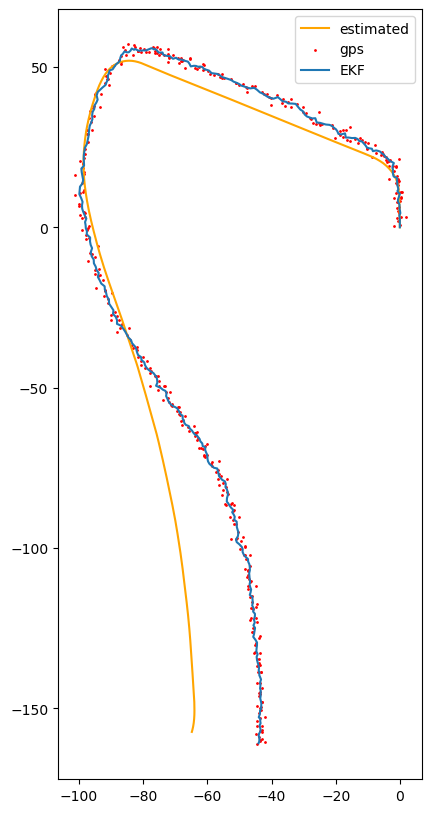

In [25]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 2], 
        label='estimated', color='orange')
ax.scatter(gps_data[:,0],gps_data[:,1],
        label='gps',color='red',s=1)
ax.plot(x_check_hist[:, 1], x_check_hist[:, 2],label='EKF')#plot your EKF result here
ax.legend()

In a similar vein, now consider a real-life fusion problem for IMU and WIFI localization. Unlike outdoor localization tasks, indoor localization tasks lack reliable GPS results and therefore often use technologies such as bluetooth, WiFi, etc. to aid localization. You are given the Informatics Forum first floor dense IMU odometer results and sparse WiFi positioning results, and use EKF to fuse them. Optionally you can incorporate the uncertainty from the WiFi localization result to the filter.


In [5]:
imu = pd.read_csv("./data/WiFi_IMU/pdr.csv")
imu = imu[['tmsp','x','y']].to_numpy() #time, odometery frame x, odometery frame y
wifi = pd.read_csv("./data/WiFi_IMU/wifi.csv")
wifi = wifi[['time','x','y','uncertainty_normalized']].to_numpy() #time, map frame x, map frame y, uncertainty

In [6]:
np.mean([imu[x+1] - imu[x] for x in range(0,len(imu)-1)]),np.mean([wifi[x+1] - wifi[x] for x in range(0,len(wifi)-1)])

(3.3333071114766852, 3331.0271325789304)

In [7]:
curr_i = 0
count = 0

for idx, i in enumerate(imu):
    if abs(i[0] - wifi[curr_i][0]) < 1.3e6:
        count += 1
        curr_i += 1
        
    if curr_i == len(wifi[:,0]):
        break
count, idx, len(imu)

(135, 48145, 48146)

In [8]:
sum(np.isin(wifi[:,0], imu[:,0])), wifi.shape

(6, (137, 4))

In [9]:
nimu = imu[::len(imu)//len(wifi)][:len(wifi)]
nimu

array([[ 1.97946380e+07, -7.07817745e-05, -1.16017100e-04],
       [ 1.97981480e+07, -1.99499256e-04, -6.59135569e-04],
       [ 1.98016580e+07, -7.35015304e-04, -5.70144675e-04],
       [ 1.98051680e+07, -1.26301685e-03, -4.19746914e-04],
       [ 1.98086780e+07, -1.69894620e-03, -3.35495681e-04],
       [ 1.98121880e+07, -2.10690223e-03, -2.87383365e-04],
       [ 1.98156980e+07, -2.51433843e-03, -2.38875088e-04],
       [ 1.98192080e+07, -2.90990204e-03, -2.09972217e-04],
       [ 1.98227180e+07, -3.43835470e-03, -4.34381124e-05],
       [ 1.98262280e+07, -1.00718379e-01,  1.43163436e-01],
       [ 1.98297380e+07, -2.88547380e-01,  2.73850571e-01],
       [ 1.98332480e+07, -2.19842430e-01,  5.51121997e-01],
       [ 1.98367580e+07, -2.31355172e-01,  2.13326105e+00],
       [ 1.98402680e+07,  4.26876382e-02,  4.09904450e+00],
       [ 1.98437780e+07, -6.16588513e-02,  5.38493649e+00],
       [ 1.98472880e+07,  2.31193705e-01,  6.22403125e+00],
       [ 1.98507980e+07,  2.16916004e+00

(137, 48146, 137)

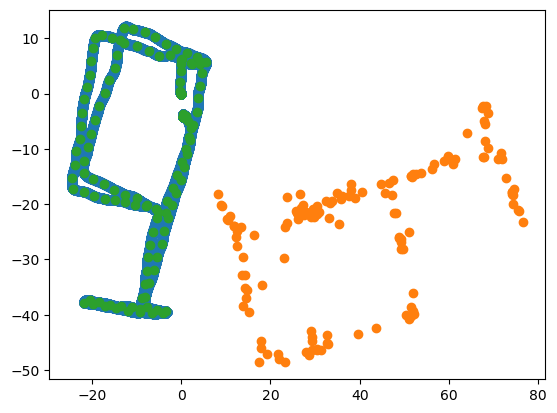

In [10]:
plt.scatter(x=imu[:,1], y=imu[:,2])
plt.scatter(x=wifi[:,1], y=wifi[:,2])
plt.scatter(x=nimu[:,1], y=nimu[:,2])
len(wifi), len(imu), len(nimu)

In [11]:
wifi[0, 1:3].tolist() + nimu[0, 1:].tolist()

([25.87315172302805, -21.61624923527732],
 [-7.078177449186952e-05, -0.000116017100324])

In [12]:
wifi

array([[ 1.97962630e+07,  2.58731517e+01, -2.16162492e+01,
         1.73863322e-02],
       [ 1.97980040e+07,  2.67134866e+01, -2.16499133e+01,
         1.38140051e-02],
       [ 1.98007140e+07,  2.62327861e+01, -2.26281195e+01,
         1.41531602e-02],
       [ 1.98024080e+07,  2.36333977e+01, -2.34504693e+01,
         1.54767949e-02],
       [ 1.98146480e+07,  2.32645706e+01, -2.42074563e+01,
         2.12250222e-02],
       [ 1.98328200e+07,  3.03167224e+01, -2.17276861e+01,
         2.26353761e-02],
       [ 1.98363500e+07,  2.70958354e+01, -2.11947796e+01,
         1.30999982e-02],
       [ 1.98432110e+07,  1.25415212e+01, -2.47771881e+01,
         9.18334350e-03],
       [ 1.98473000e+07,  1.21694195e+01, -2.58696094e+01,
         9.40514728e-03],
       [ 1.98509910e+07,  1.18092970e+01, -2.40165124e+01,
         1.09654488e-02],
       [ 1.98565010e+07,  1.02291189e+01, -2.26383256e+01,
         3.64732891e-02],
       [ 1.98578710e+07,  8.88001701e+00, -2.01964610e+01,
      

In [32]:
x_init = np.array(wifi[0, 1:3].tolist() + nimu[0, 1:].tolist())
x_hist = np.zeros([len(nimu), 4])
x_hist[0] = x_init

P_hist = np.zeros([len(nimu) , 4, 4])  # state covariance matrices

for i in range(1, len(nimu)):
    delta_t = (wifi[i, 0] - wifi[i-1, 0]) 
    print(delta_t)
    
    
    curr_imu = nimu[i]
    curr_wifi = wifi[i]
    
    x_k1 = x_hist[i-1]
    F_k1 = np.eye(4)
    F_k1[0,2] = delta_t 
    F_k1[1,3] = delta_t
    
    G_k1 = np.zeros((4,2))
    G_k1[2,0] = delta_t
    G_k1[3,1] = delta_t
    
    L_k1 = 0.1 * np.eye(4)
    
    P_k1 = P_hist[i-1]

    x_k = F_k1 @ x_k1 + G_k1 @ curr_imu[1:]
    
    P_est = F_k1 @ P_k1 @ F_k1.T + L_k1 @ (0.1*np.eye(4)) @ L_k1.T

    H = np.zeros((4,4)) 
    H[0,0] = 1 
    H[1,1] = 1 
    H_k = H @ x_k
    
    K = P_est @ H_k.T * (H_k @ P_est @ H_k.T + 0)**(-1)
    
    y_k = np.zeros(4)
    y_k[0] = curr_wifi[1]
    y_k[1] = curr_wifi[2] 
    
    x_pred = x_k + K @ (y_k - H_k)
    
    x_pred = x_k
    
    print((K@H_k).shape, (1 - K @ H_k).shape, P_est.shape)
    P_check = (1 - K @ H_k) * P_est
    
    print("f_k1", F_k1)
    print("x_k1: ", x_k1)
    print("x_k: ", x_k)
    print("P_est: ", P_est)
    print("h_k: ", H_k)
    print("K: ", K)
    print("y_k: ", y_k)
    print("x_pred: ", x_pred)
    print("P_check: ", P_check)
    

    x_hist[i] = x_pred
    P_hist[i] = P_check
    
    

1741.0
() () (4, 4)
f_k1 [[1.000e+00 0.000e+00 1.741e+03 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 1.741e+03]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00]]
x_k1:  [ 2.58731517e+01 -2.16162492e+01 -7.07817745e-05 -1.16017100e-04]
x_k:  [ 25.74992065 -21.81823501  -0.34739899  -1.14767104]
P_est:  [[0.001 0.    0.    0.   ]
 [0.    0.001 0.    0.   ]
 [0.    0.    0.001 0.   ]
 [0.    0.    0.    0.001]]
h_k:  [ 25.74992065 -21.81823501   0.           0.        ]
K:  [ 0.02260562 -0.01915403  0.          0.        ]
y_k:  [ 26.71348664 -21.64991333   0.           0.        ]
x_pred:  [ 25.74992065 -21.81823501  -0.34739899  -1.14767104]
P_check:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
2710.0
() () (4, 4)
f_k1 [[1.00e+00 0.00e+00 2.71e+03 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 2.71e+03]
 [0.00e+00 0.00e+00 1.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00]]
x_k1:  [ 25.74992065 -21.81823501  -0.34739899  -1.14767104]
x

Plot your result on the floor plan:

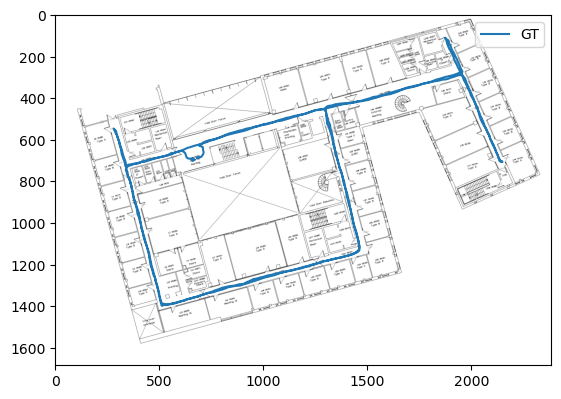

In [33]:
def meter2pixel(x,y,fig_resolution=72,fig_scale=100):
    pix_x=x/0.0254/fig_scale*fig_resolution
    pix_y=-y/0.0254/fig_scale*fig_resolution
    return pix_x,pix_y

floorplan = plt.imread("./data/WiFi_IMU/F1.png")
gt = np.load("./data/WiFi_IMU/gt_9.npy")
gtx_pixel,gty_pixel= meter2pixel(gt[:,1],gt[:,2])

plt.imshow(floorplan)
plt.plot(gtx_pixel,gty_pixel,label="GT")
plt.legend()

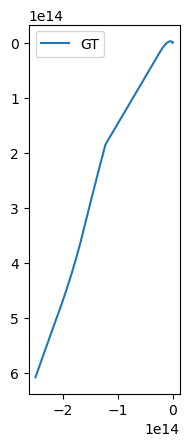

In [34]:
predx_pixel,predy_pixel= meter2pixel(x_hist[:,0],x_hist[:,1])

plt.imshow(floorplan)
plt.plot(predx_pixel,predy_pixel,label="GT")
plt.legend()

In [35]:
gt

array([[ 1.97949616e+06,  2.35812543e+01, -2.44972688e+01],
       [ 1.97950616e+06,  2.35812289e+01, -2.44972104e+01],
       [ 1.97951616e+06,  2.35812036e+01, -2.44971519e+01],
       ...,
       [ 2.02502616e+06,  2.40614337e+01, -2.41954587e+01],
       [ 2.02503616e+06,  2.40573345e+01, -2.41966301e+01],
       [ 2.02504616e+06,  2.40532354e+01, -2.41978016e+01]])

In [36]:
x_hist[:,0]

array([ 2.58731517e+01,  2.57499207e+01, -9.15701333e+02, -4.87845937e+03,
       -5.96994733e+04, -5.18977557e+05, -7.43346369e+05, -1.24033103e+06,
       -1.61815881e+06, -2.01110435e+06, -4.64605243e+06, -7.47936046e+06,
       -3.36410848e+07, -4.83045066e+07, -6.96406383e+07, -1.23125011e+08,
       -1.34316409e+08, -1.08094384e+08,  1.17685404e+08,  8.91448808e+08,
        1.18450386e+09,  1.39296634e+09,  1.58302650e+09,  2.21967778e+09,
        2.32444751e+09,  2.21281593e+09,  9.42531586e+08,  1.07884882e+08,
       -4.95819319e+09, -6.77990204e+09, -2.02155951e+10, -2.56875742e+10,
       -3.02825300e+10, -3.52478738e+10, -3.74691902e+10, -4.20136617e+10,
       -5.03934833e+10, -5.38396058e+10, -6.32137615e+10, -6.69012894e+10,
       -7.33457610e+10, -7.65418712e+10, -8.12692775e+10, -8.83208395e+10,
       -9.44033171e+10, -1.06332823e+11, -1.15897839e+11, -1.24978203e+11,
       -1.38546680e+11, -1.43666836e+11, -1.48132041e+11, -1.65747431e+11,
       -1.69731117e+11, -

In [37]:
x_hist[:,1]

array([-2.16162492e+01, -2.18182350e+01, -3.13200676e+03, -7.69354747e+03,
       -4.93562355e+04, -1.85833071e+05, -2.30779192e+05, -3.23923037e+05,
       -3.85325344e+05, -4.41406690e+05,  2.38644743e+06,  5.15677759e+06,
        3.58223544e+07,  1.14240970e+08,  2.85665106e+08,  9.44766083e+08,
        1.48947500e+09,  2.09398705e+09,  3.79244563e+09,  6.42392501e+09,
        7.31336085e+09,  7.98787992e+09,  8.67022799e+09,  1.13677378e+10,
        1.32564029e+10,  1.52657734e+10,  2.27074141e+10,  2.43742398e+10,
        3.35847229e+10,  3.59025725e+10,  5.20439156e+10,  5.68111292e+10,
        6.05320784e+10,  6.43123021e+10,  6.58900930e+10,  6.90144777e+10,
        7.43737905e+10,  7.62953316e+10,  8.12310952e+10,  8.28727028e+10,
        8.55502285e+10,  8.67176651e+10,  8.83404131e+10,  9.05448785e+10,
        9.21916988e+10,  9.50315183e+10,  9.67442097e+10,  9.79744283e+10,
        9.92840440e+10,  9.94895303e+10,  9.95697146e+10,  9.95133820e+10,
        9.91484011e+10,  